In [ ]:
import numpy as np
import cv2

import os
import io

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub  

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import tensorflow_datasets as tfds

In [2]:
import kagglehub
import pathlib

# Download dataset
dataset_path = kagglehub.dataset_download("mdhasanahmad/12-mushroom-species-dataset")
dataset_path = os.path.join(dataset_path, "Data")

data_dir = pathlib.Path(dataset_path)

print("Dataset downloaded to:", data_dir)
print("Dataset contents:", os.listdir(data_dir))

c:\Users\Karylle\Documents\Documents\BSCS-3\AI\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\Karylle\.cache\kagglehub\datasets\mdhasanahmad\12-mushroom-species-dataset\versions\1\Data
Dataset contents: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']


In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

image_classes = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']
print("Dataset folder contents:", os.listdir(dataset_path))
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path): 
        print("Found class:", item)
        # print(os.path.join(dataset_path, "Data"+))


Dataset folder contents: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']
Found class: Agaricus
Found class: Amanita
Found class: Boletus
Found class: Cortinarius
Found class: Entoloma
Found class: Exidia
Found class: Hygrocybe
Found class: Inocybe
Found class: Lactarius
Found class: Pluteus
Found class: Russula
Found class: Suillus


In [4]:
import tensorflow as tf
import pathlib

dataset_path = pathlib.Path(dataset_path)

full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

total_images = len(full_dataset.file_paths)

# Define split sizes - 75% for training, 15% for validation, 10% for testing
train_size = int(0.75 * total_images)   
valid_size = int(0.15 * total_images)   
test_size = total_images - (train_size + valid_size)  

print(f"Total images: {total_images}, Train: {train_size}, Validation: {valid_size}, Test: {test_size}")

# Training + Validation Dataset (90%)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1667, 
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1667,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=None,  
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_dataset = test_dataset.skip(train_size + valid_size)  

Found 12000 files belonging to 12 classes.
Total images: 12000, Train: 9000, Validation: 1800, Test: 1200
Found 12000 files belonging to 12 classes.
Using 10000 files for training.
Found 12000 files belonging to 12 classes.
Using 2000 files for validation.
Found 12000 files belonging to 12 classes.


In [5]:
# Split validation (25%) into validation (15%) and test (10%)
total_batches = len(validation_dataset)
val_batches = int(total_batches * (15 / 25))
test_batches = total_batches - val_batches

valid_dataset = validation_dataset.take(val_batches)
test_dataset = validation_dataset.skip(val_batches)

print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(valid_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Train batches: 313
Validation batches: 37
Test batches: 26


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

def preprocess(image, label):
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label


In [7]:
train_set = (train_dataset
             .map(lambda x, y: (data_augmentation(x, training=True), y))
             .shuffle(1000)
             .map(preprocess)
)

valid_set = (valid_dataset
             .map(preprocess))

test_set = (test_dataset
            .map(preprocess))


In [8]:
base_model = tf.keras.applications.Xception(weights="imagenet",
                                            include_top=False)

In [9]:
for layer in base_model.layers[:50]:
  layer.trainable = False

In [10]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
) 

Epoch 1/10


313/313 [==============================] - 1038s 3s/step - loss: 1.9228 - accuracy: 0.3641 - val_loss: 1.5262 - val_accuracy: 0.5262 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 1448s 4s/step - loss: 1.3555 - accuracy: 0.5788 - val_loss: 1.0495 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 1622s 5s/step - loss: 1.0520 - accuracy: 0.6813 - val_loss: 1.0185 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 1076s 3s/step - loss: 0.9085 - accuracy: 0.7268 - val_loss: 0.7991 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 981s 3s/step - loss: 0.7635 - accuracy: 0.7708 - val_loss: 0.6714 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 6/10
313/313 [==============================] - 2856s 9s/step - loss: 0.6848 - accuracy: 0.7990 - val_loss: 0.6347 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 7/10
313/313 [==============================] - 964

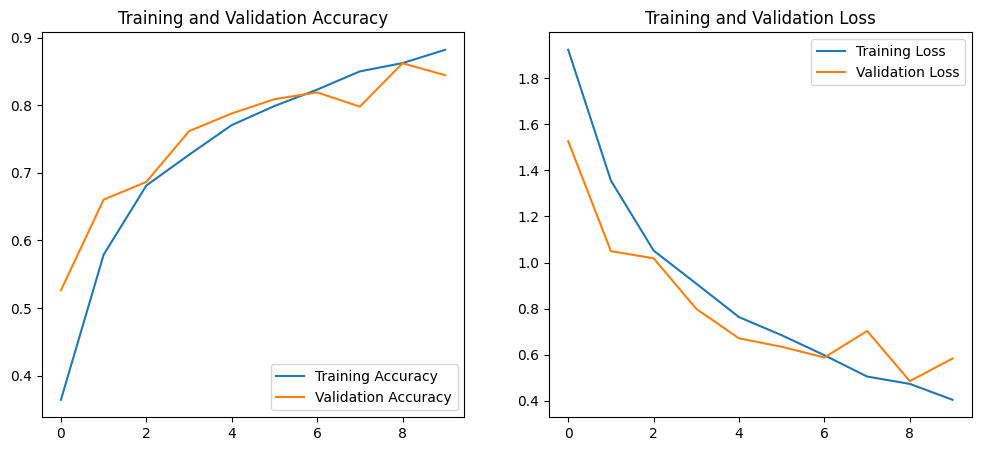

In [12]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))    

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [13]:
model.save("MushroomClassifierModelV1.h5")

c:\Users\Karylle\Documents\Documents\BSCS-3\AI\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# model.evaluate(test_dataset,y_test)
test_loss, test_acc = model.evaluate(test_set, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

26/26 [==============================] - 24s 918ms/step - loss: 0.6793 - accuracy: 0.8150
Test Accuracy: 0.8150


1/1 [==============================] - 1s 1s/step


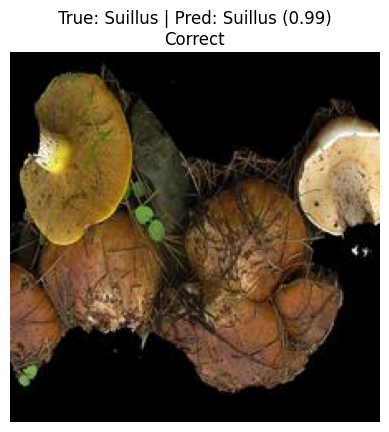

[Correct] True: Suillus — Predicted: Suillus (Confidence: 0.99)
1/1 [==============================] - 0s 133ms/step


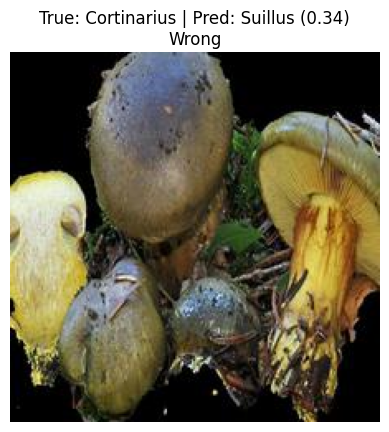

[Wrong] True: Cortinarius — Predicted: Suillus (Confidence: 0.34)


In [25]:
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model("MushroomClassifierModelV1.h5") 

def predict_and_show(img_path, true_label):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = tf.argmax(predictions[0]).numpy()
    predicted_class = image_classes[predicted_index]
    confidence = predictions[0][predicted_index]

    is_correct = (predicted_class.lower() == true_label.lower())
    # result_color = "green" if is_correct else "red"
    result_status = "Correct" if is_correct else "Wrong"

    plt.imshow(img)
    plt.title(
        f"True: {true_label} | Pred: {predicted_class} ({confidence:.2f})\n{result_status}"
    )
    plt.axis('off')
    plt.show()

    print(f"[{result_status}] True: {true_label} — Predicted: {predicted_class} (Confidence: {confidence:.2f})")

predict_and_show(
    r"C:\Users\Karylle\Desktop\Suillus_original_002__QuxTmpPRBQ.jpg_2ed17251-15ca-4a83-92cb-e4a16aba9891.jpg",
    true_label="Suillus"
)

predict_and_show(
    r"C:\Users\Karylle\Desktop\Cortinarius_original_000_Pw3qUBVmwN8.jpg_ed186931-ad06-4975-bf34-f42d474f65d5.jpg",
    true_label="Cortinarius"
)
